In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

from tensorflow_graph_in_jupyter import show_graph
import tensorflow as tf
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
import tfgraphviz as tfg
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
from tensorboard import notebook

In [2]:
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs2"
logdir = "{}/run-{}/".format(root_logdir, now)

print(logdir)

tf_logs2/run-20200609170238/


In [3]:
N = 1000
xx, yy = make_moons(N, noise=0.1, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(xx, yy, random_state=42, test_size=0.2)

In [4]:
scaler = StandardScaler()
x = scaler.fit_transform(x_train)
x = np.c_[np.ones((len(x_train), 1)),x, np.square(x), np.power(x,3)]

In [5]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(len(x), size=batch_size)
    X_batch = x[indices]
    y_batch = y_train.reshape(-1, 1)[indices]
    return X_batch, y_batch

In [6]:
reset_graph()

n_epochs = 400
learning_rate = 1.5
batch_size = 1
n_batches = int(np.ceil(len(x) / batch_size))
degree = 7

X = tf.placeholder(tf.float32, shape=(None, degree), name="X")
Y = tf.placeholder(tf.float32, shape=(None, 1), name="Y")
theta = tf.Variable(tf.random_uniform([degree, 1], -1.0, 1.0), name="theta")
y_pred = tf.sigmoid(tf.matmul(X, theta, name="predictions"))

with tf.name_scope("loss") as scope:
    error = y_pred - Y
    mse = tf.reduce_mean(tf.square(error), name="mse")

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [7]:
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [8]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, Y: y_batch})
            
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, Y: y_batch})
                step = epoch * n_batches * batch_index
                file_writer.add_summary(summary_str, step)
                
            if epoch % 100 == 0 and batch_index == n_batches-1:
                print("Epoch", epoch, "MSE =", mse.eval(feed_dict={X: X_batch, Y: y_batch}))
                save_path = saver.save(sess, "./tmp2/my_model.ckpt")
            
    best_theta = theta.eval()
    save_path = saver.save(sess, "./tmp2/my_final_model.ckpt")
    


Epoch 0 MSE = 4.020933e-07
Epoch 100 MSE = 6.986598e-06
Epoch 200 MSE = 5.287859e-11
Epoch 300 MSE = 0.0


In [9]:
file_writer.close()

In [10]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
#%reload_ext tensorboard

In [11]:
%tensorboard --logdir tf_logs1

Reusing TensorBoard on port 6006 (pid 4808), started 3:43:18 ago. (Use '!kill 4808' to kill it.)

In [12]:
with tf.Session() as sess:
    saver.restore(sess, "./tmp2/my_model.ckpt")
    best_theta_restored = theta.eval()

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./tmp2/my_model.ckpt


In [13]:
reset_graph()
# notice that we start with an empty graph.

saver = tf.train.import_meta_graph("./tmp2/my_final_model.ckpt.meta") 
theta = tf.get_default_graph().get_tensor_by_name("theta:0")

with tf.Session() as sess:
    saver.restore(sess, "./tmp2/my_final_model.ckpt")  # this restores the graph's state
    best_theta_restored = theta.eval()
    best_theta = best_theta_restored

INFO:tensorflow:Restoring parameters from ./tmp2/my_final_model.ckpt


Precision score:  1.0


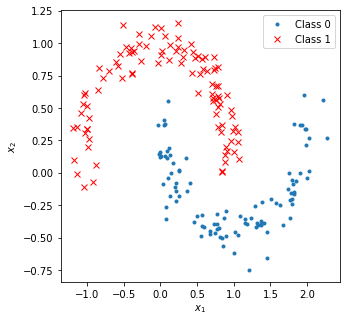

In [15]:
reset_graph()

scaler = StandardScaler()
x = scaler.fit_transform(x_test)
x = np.c_[np.ones((len(x), 1)), x, np.power(x, 2), np.power(x, 3)]

X = tf.constant(x, dtype=tf.float32, name="X")
Y = tf.constant(y_test.reshape(-1, 1), dtype=tf.float32, name="Y")
y_pred = tf.sigmoid(tf.matmul(X, best_theta, name="predictions"))

error = y_pred - Y
mse = tf.reduce_mean(tf.square(error), name="mse")

init = tf.global_variables_initializer()

yreal = []
ypred = []

with tf.Session() as sess:
    sess.run(init)
    
    yreal = (Y.eval() >= 0.5)
    ypred = (y_pred.eval() >= 0.5)
    ps = precision_score(yreal, ypred)
    print("Precision score: ", ps)
    
ypredd = ypred.reshape(-1)

fig = plt.figure(figsize=(5,5))
plt.plot(x_test[ypredd,0], x_test[ypredd,1], '.', label='Class 0')
plt.plot(x_test[~ypredd,0], x_test[~ypredd,1], 'rx', label='Class 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()
